In [1]:
from geopy.distance import distance
from shapely.ops import unary_union

import pandas as pd
from datetime import datetime

from shapely import Point, Polygon
from shapely.geometry import mapping
import json

from shapely.geometry import Point
from shapely.ops import transform
import pyproj

from shapely import from_wkt

In [ ]:
df = pd.read_csv('locs_sorted_dist.csv')
locs = df['Google Location'].to_list()

# 
startpoint_ = '59.32493573672165, 18.069355309000265'
startpoint = Point(startpoint_)

dist_dict = {}
for loc in locs:
    dist_dict[loc] = distance(loc,startpoint).m
df['dist_to_start_point'] = df['Google Location'].apply(lambda x: dist_dict[x])

In [2]:
def create_pol_with_points_buffer(points, buffer_in_meter):
    pol = Polygon()
    # for point in points:
    #     pol = pol.union(point.buffer(buffer_in_meter))
    li = [point.buffer(buffer_in_meter) for point in points]
    pol = unary_union(li)
    return pol

def save_geojson(pol, fname='result_polygon.geojson'):
    res = mapping(pol)
    with open(fname, "w") as file:
        json.dump(res, file)

def save_wkt(pol, fname = 'test_wkt.wkt'):
    with open(fname,'w') as f:
        f.write(pol.wkt)

# Function to transform coordinates from WGS 84 to a local coordinate system
def wsgPointsToLocal(points):
    transformer = pyproj.Transformer.from_proj(
        pyproj.Proj(init='EPSG:4326'),  # WGS 84
        pyproj.Proj(init='EPSG:3006')  # 3408 stockholm or 3006 sweden
    )

    start = datetime.now()
    new_points = []
    for i, point in enumerate(points):
        if i % 10000 == 9999:
            print(i, datetime.now()-start)
        
        new_points.append(transform(transformer.transform, point))

    return new_points

def pol_to_wsg84(pol):
    transformer = pyproj.Transformer.from_proj(
        pyproj.Proj(init='EPSG:3006'),  # 3408 stockholm or 3006 sweden
        pyproj.Proj(init='EPSG:4326')  # WGS 84
    )

    polygon_wgs84 = transform(transformer.transform, pol)
    return polygon_wgs84

def create_pol_with_points_buffer(points, buffer_in_meter):
    points = wsgPointsToLocal(points)

    pol = Polygon()
    #for point in points:
    #    pol = pol.union(point.buffer(buffer_in_meter))
    li = [point.buffer(buffer_in_meter) for point in points]
    pol = unary_union(li)
    
    polwsg84 = pol_to_wsg84(pol)
    return polwsg84

In [3]:
df = pd.read_csv('locs_sorted_dist.csv')
df['points'] = df['points'].apply(lambda x: from_wkt(x))
#startpoint = 59.32493573672165, 18.069355309000265

/Users/adrian/miniconda3/envs/geolocation/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/adrian/miniconda3/envs/geolocation/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9999 0:00:00.216953
19999 0:00:00.425551
29999 0:00:00.634257
39999 0:00:00.843535


/Users/adrian/miniconda3/envs/geolocation/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/adrian/miniconda3/envs/geolocation/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


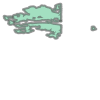

In [4]:
p = create_pol_with_points_buffer(df['points'].to_list(), 100)
p

In [89]:
from os import listdir

In [90]:
dirname = 'buffer_csvs/'
prev_iterations = [dirname+fname for fname in listdir(dirname) if '.csv' in fname]

In [91]:
prev_iteration_csvs = [pd.read_csv(path) for path in prev_iterations]

In [92]:
new_order = pd.concat(prev_iteration_csvs)
new_order['points'] = new_order['points'].apply(lambda x: from_wkt(x))

In [93]:
not_available_loc_IDs = new_order.sorted_idx.to_list()
not_available_points = new_order.points
df_available = df.copy()

mask_not_available = [idx in not_available_loc_IDs for idx in df_available.sorted_idx.to_list()]
mask_available = [not available for available in mask_not_available]
df_not_available = df_available[mask_not_available]
df_available = df_available[mask_available]

In [94]:
prev_buffers = [int(x.split('.')[0].split('buffer_')[1]) for x in prev_iterations]
min_buffer = min(prev_buffers) - 5 

buffer = 35
if buffer > min_buffer:
    buffer = min_buffer
df_new_order = []

#df_not_available['SWEREF_Points'] = df_not_available['SWEREF_Points'].apply(lambda x: from_wkt(x))
pol = create_pol_with_points_buffer(df_not_available['points'].to_list(), buffer)

#df_available['SWEREF_Points'] = df_available['SWEREF_Points'].apply(lambda x: from_wkt(x))
available_points = df_available['points'].to_list()

point_not_in_polygon = [not pol.contains(p) for p in available_points]
df_available = df_available[point_not_in_polygon]

/Users/adrian/miniconda3/envs/geolocation/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/adrian/miniconda3/envs/geolocation/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/adrian/miniconda3/envs/geolocation/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<auth

In [80]:
buffer

35

In [95]:
len(df_available)

2558

In [82]:
df_available['SWEREF_Points'] = df_available['SWEREF_Points'].apply(lambda x: from_wkt(x))

In [83]:
it = 0
start = datetime.now()
while len(df_available) > 0:
    it+=1
    if it % 300 == 99:
        print(it, datetime.now()-start, len(df_available))
    item = df_available.iloc[0]
    loc_idx, point = item.Location_idx, item.SWEREF_Points
    new_pol = point.buffer(buffer)
    #pol = pol.union(new_pol)
    
    #item['new_ID'] = current_id
    df_new_order.append(item)

    available_points = df_available.SWEREF_Points.to_list()
    point_not_in_polygon = [not new_pol.contains(p) for p in available_points]
    df_available = df_available[point_not_in_polygon]


99 0:00:01.918552 3105
399 0:00:06.234693 2491
699 0:00:09.426239 1871
999 0:00:11.671673 1221
1299 0:00:13.041079 548


In [84]:
new_order = pd.DataFrame(df_new_order)

In [85]:
new_start_idx = len(pd.concat(prev_iteration_csvs))
relative_last_idx = len(new_order)

new_order.index = pd.RangeIndex(new_start_idx, new_start_idx+relative_last_idx)
new_order = new_order.reset_index()

In [86]:
new_order.columns = ['new_order_idx', 'sorted_idx', 'Location_idx', 'Location', 'Copyright',
       'Date', 'Latitude', 'Longitude', 'PanoID', 'Status', 'Google Location',
       'dist_to_start_point', 'points', 'SWEREF_Points']

In [87]:
new_order

,new_order_idx,sorted_idx,Location_idx,Location,Copyright,Date,Latitude,Longitude,PanoID,Status,Google Location,dist_to_start_point,points,SWEREF_Points
0,5006,19,141396,"59.32469375471698, 18.066711208955223",© Google,2023-03,59.324686,18.066646,cep7tpspfwNPgpPnn7rKCQ,OK,"59.32468607475585, 18.06664594436918",156.739750,POINT (18.06664594436918 59.32468607475585),POINT (674484.4102557271 6580224.450299655)
1,5007,47,142800,"59.32352679622642, 18.067239001865673",© Google,2023-03,59.323573,18.067270,d4tHFCgH9zGHwCQqgI7UAQ,OK,"59.32357339189574, 18.06726953793246",192.704040,POINT (18.06726953793246 59.32357339189574),POINT (674525.5813225454 6580102.265652825)
2,5008,62,143733,"59.32325749811321, 18.067590863805968",© Google,2023-03,59.323269,18.067692,qfxWXQd7EqUqanThbo-SeQ,OK,"59.32326939506412, 18.06769214727672",208.387801,POINT (18.06769214727672 59.32326939506412),POINT (674551.1757479494 6580069.544780961)
3,5009,74,147383,"59.32280866792453, 18.068998311567164",© Google,2010-08,59.322881,18.069082,0h1b2xqwcsbN4uVHA9V4HA,OK,"59.32288133051109, 18.0690821033474",229.390324,POINT (18.0690821033474 59.32288133051109),POINT (674632.2190899227 6580030.00569647)
4,5010,139,161638,"59.3264890754717, 18.07445217164179",© Google,2023-03,59.326482,18.074588,thAJVLgyW4aH69qX99HZug,OK,"59.32648201898998, 18.07458766586639",344.105648,POINT (18.07458766586639 59.32648201898998),POINT (674926.8336147363 6580445.139999251)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,6557,47529,286092,"59.30736890943396, 18.160658347014927",© Google,2022-08,59.307386,18.160729,tdm01hgc49FCPvORtdHFJA,OK,"59.30738611329635, 18.16072912207322",5558.661244,POINT (18.16072912207322 59.30738611329635),POINT (679926.35909818 6578549.730290601)
1552,6558,47619,286713,"59.30889493207547, 18.16259358768657",© Google,2023-03,59.309039,18.163152,PHNc4shOXrKZoMlR2Wdi4g,OK,"59.30903900196483, 18.16315249584627",5627.302276,POINT (18.16315249584627 59.30903900196483),POINT (680055.5033374208 6578740.204860185)
1553,6559,47636,286635,"59.3077279735849, 18.162417656716418",© Google,2022-08,59.307689,18.162552,uZk1pRlKB95F4w7FA5TS-Q,OK,"59.30768857396323, 18.16255168611466",5644.357854,POINT (18.16255168611466 59.30768857396323),POINT (680028.4600157845 6578588.3121763505)
1554,6560,47656,287024,"59.308535867924526, 18.163649173507462",© Google,2022-04,59.308529,18.163623,VlArRLvMVAULNRNzqF1ixw,OK,"59.3085294293578, 18.1636225426302",5670.794225,POINT (18.1636225426302 59.3085294293578),POINT (680084.9417498277 6578684.773410729)


In [88]:
new_order.to_csv(f'buffer_csvs/new_order_buffer_{buffer}.csv',index=False)